In [150]:
import glob
from pathlib import Path
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm

## Preprocessing funcions

In [72]:
def cropBorders(img, l=0.01, r=0.01, u=0.04, d=0.04):

    """
    This function crops a specified percentage of border from
    each side of the given image. Default is 1% from the top,
    left and right sides and 4% from the bottom side.

    Parameters
    ----------
    img : {numpy.ndarray}
        The image to crop.

    Returns
    -------
    cropped_img: {numpy.ndarray}
        The cropped image.
    """

    try:
        nrows, ncols = img.shape

        # Get the start and end rows and columns
        l_crop = int(ncols * l)
        r_crop = int(ncols * (1 - r))
        u_crop = int(nrows * u)
        d_crop = int(nrows * (1 - d))

        cropped_img = img[u_crop:d_crop, l_crop:r_crop]

    except Exception as e:
        # logger.error(f'Unable to cropBorders!\n{e}')
        print((f"Unable to get cropBorders!\n{e}"))

    return cropped_img

In [101]:
def globalBinarise(img, thresh, maxval):

    """
    This function takes in a numpy array image and
    returns a corresponding mask that is a global
    binarisation on it based on a given threshold
    and maxval. Any elements in the array that is
    greater than or equals to the given threshold
    will be assigned maxval, else zero.

    Parameters
    ----------
    img : {numpy.ndarray}
        The image to perform binarisation on.
    thresh : {int or float}
        The global threshold for binarisation.
    maxval : {np.uint8}
        The value assigned to an element that is greater
        than or equals to `thresh`.


    Returns
    -------
    binarised_img : {numpy.ndarray, dtype=np.uint8}
        A binarised image of {0, 1}.
    """

    try:
        binarised_img = np.zeros(img.shape, np.uint8)
        binarised_img[img >= thresh] = maxval

    except Exception as e:
        # logger.error(f'Unable to globalBinarise!\n{e}')
        print((f"Unable to globalBinarise!\n{e}"))

    return binarised_img

In [102]:
def OwnGlobalBinarise(img, thresh, maxval):
    
    '''
    This function takes in a numpy array image and
    returns a corresponding mask that is a global
    binarisation on it based on a given threshold
    and maxval. Any elements in the array that is
    greater than or equals to the given threshold
    will be assigned maxval, else zero.
    
    Parameters
    ----------
    img : {numpy.ndarray}
        The image to perform binarisation on.
    thresh : {int or float}
        The global threshold for binarisation.
    maxval : {np.uint8}
        The value assigned to an element that is greater
        than or equals to `thresh`.
        
        
    Returns
    -------
    binarised_img : {numpy.ndarray, dtype=np.uint8}
        A binarised image of {0, 1}.
    '''
    
    binarised_img = np.zeros(img.shape, np.uint8)
    binarised_img[img >= thresh] = maxval
    
    return binarised_img

In [103]:
def editMask(mask, ksize=(23, 23), operation="open"):

    """
    This function edits a given mask (binary image) by performing
    closing then opening morphological operations.

    Parameters
    ----------
    mask : {numpy.ndarray}
        The mask to edit.
    ksize : {tuple}
        Size of the structuring element.
    operation : {str}
        Either "open" or "close", each representing open and close
        morphological operations respectively.

    Returns
    -------
    edited_mask : {numpy.ndarray}
        The mask after performing close and open morphological
        operations.
    """

    try:
        kernel = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=ksize)

        if operation == "open":
            edited_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        elif operation == "close":
            edited_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        # Then dilate
        edited_mask = cv2.morphologyEx(edited_mask, cv2.MORPH_DILATE, kernel)

    except Exception as e:
        # logger.error(f'Unable to editMask!\n{e}')
        print((f"Unable to get editMask!\n{e}"))

    return edited_mask

In [104]:
def xLargestBlobs(mask, top_x=None, reverse=True):

    """
    This function finds contours in the given image and
    keeps only the top X largest ones.

    Parameters
    ----------
    mask : {numpy.ndarray, dtype=np.uint8}
        The mask to get the top X largest blobs.
    top_x : {int}
        The top X contours to keep based on contour area
        ranked in decesnding order.


    Returns
    -------
    n_contours : {int}
        The number of contours found in the given `mask`.
    X_largest_blobs : {numpy.ndarray}
        The corresponding mask of the image containing only
        the top X largest contours in white.
    """
    try:
        # Find all contours from binarised image.
        # Note: parts of the image that you want to get should be white.
        contours, hierarchy = cv2.findContours(
            image=mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE
        )

        n_contours = len(contours)

        # Only get largest blob if there is at least 1 contour.
        if n_contours > 0:

            # Make sure that the number of contours to keep is at most equal
            # to the number of contours present in the mask.
            if n_contours < top_x or top_x == None:
                top_x = n_contours

            # Sort contours based on contour area.
            sorted_contours, bounding_boxes = sortContoursByArea(
                contours=contours, reverse=reverse
            )

            # Get the top X largest contours.
            X_largest_contours = sorted_contours[0:top_x]

            # Create black canvas to draw contours on.
            to_draw_on = np.zeros(mask.shape, np.uint8)

            # Draw contours in X_largest_contours.
            X_largest_blobs = cv2.drawContours(
                image=to_draw_on,  # Draw the contours on `to_draw_on`.
                contours=X_largest_contours,  # List of contours to draw.
                contourIdx=-1,  # Draw all contours in `contours`.
                color=1,  # Draw the contours in white.
                thickness=-1,  # Thickness of the contour lines.
            )

    except Exception as e:
        # logger.error(f'Unable to xLargestBlobs!\n{e}')
        print((f"Unable to get xLargestBlobs!\n{e}"))

    return n_contours, X_largest_blobs

In [105]:
def applyMask(img, mask):

    """
    This function applies a mask to a given image. White
    areas of the mask are kept, while black areas are
    removed.

    Parameters
    ----------
    img : {numpy.ndarray}
        The image to mask.
    mask : {numpy.ndarray, dtype=np.uint8}
        The mask to apply.

    Returns
    -------
    masked_img: {numpy.ndarray}
        The masked image.
    """

    try:
        masked_img = img.copy()
        masked_img[mask == 0] = 0

    except Exception as e:
        # logger.error(f'Unable to applyMask!\n{e}')
        print((f"Unable to get applyMask!\n{e}"))

    return masked_img

In [114]:
def sortContoursByArea(contours, reverse=True):

    """
    This function takes in list of contours, sorts them based
    on contour area, computes the bounding rectangle for each
    contour, and outputs the sorted contours and their
    corresponding bounding rectangles.

    Parameters
    ----------
    contours : {list}
        The list of contours to sort.

    Returns
    -------
    sorted_contours : {list}
        The list of contours sorted by contour area in descending
        order.
    bounding_boxes : {list}
        The list of bounding boxes ordered corresponding to the
        contours in `sorted_contours`.
    """

    try:
        # Sort contours based on contour area.
        sorted_contours = sorted(contours, key=cv2.contourArea, reverse=reverse)

        # Construct the list of corresponding bounding boxes.
        bounding_boxes = [cv2.boundingRect(c) for c in sorted_contours]

    except Exception as e:
        # logger.error(f'Unable to sortContourByArea!\n{e}')
        print((f"Unable to get sortContourByArea!\n{e}"))

    return sorted_contours, bounding_boxes

## Main Code

In [162]:
#Paths
original_train_folder_dcm = '/datasets/mamografia/CBIS-DDSM_organized/images/original/train/'
output_train_full_path = "/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/train/full/" 
output_train_mask_path = "/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/train/mask/"

os.makedirs(output_train_full_path, exist_ok=True) 
os.makedirs(output_train_mask_path, exist_ok=True) 

original_test_folder_dcm = '/datasets/mamografia/CBIS-DDSM_organized/images/original/test/'
output_test_full_path = "/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/full/"
output_test_mask_path = "/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/"

os.makedirs(output_test_full_path, exist_ok=True) 
os.makedirs(output_test_mask_path, exist_ok=True) 

In [131]:
#Parameters
output_format = "png"

# Get all hyperparameters.
# l = config_imgPre["cropBorders"]["l"]
# r = config_imgPre["cropBorders"]["r"]
# u = config_imgPre["cropBorders"]["u"]
# d = config_imgPre["cropBorders"]["d"]
# thresh = config_imgPre["globalBinarise"]["thresh"]
# maxval = config_imgPre["globalBinarise"]["maxval"]
# ksize = config_imgPre["editMask"]["ksize"]
# operation = config_imgPre["editMask"]["operation"]
# reverse = config_imgPre["sortContourByArea"]["reverse"]
# top_x = config_imgPre["xLargestBlobs"]["top_x"]
# clip = config_imgPre["clahe"]["clip"]
# tile = config_imgPre["clahe"]["tile"]

In [163]:
fullmamm_paths_train  = glob.glob(original_train_folder_dcm + "*FULL.dcm")
mask_paths_train  = glob.glob(original_train_folder_dcm + "*MASK*")

fullmamm_paths_test  = glob.glob(original_test_folder_dcm + "*FULL.dcm")
mask_paths_test  = glob.glob(original_test_folder_dcm + "*MASK*")
      

In [62]:
len(fullmamm_paths_train)

1231

In [120]:
fullmamm_paths_train[0]

'/datasets/mamografia/CBIS-DDSM_organized/images/original/train/Mass-Training_P_01222_LEFT_MLO_FULL.dcm'

In [63]:
len(mask_paths_train)

1318

In [148]:
#Preprocess training images

nsamples = 5

sample_original = fullmamm_paths_train[:nsamples]

sample_initial = []
sample_final  = []

count=0

for fullmamm_path in fullmamm_paths_train:
# for fullmamm_path in sample_original:
    # Read full mammogram .dcm file.
    ds = pydicom.dcmread(fullmamm_path)

    # Get relevant metadata from .dcm file.
    patient_id = ds.PatientID
    
    fullmamm = ds.pixel_array
    
    # =========================
    # Preprocess Full Mammogram
    # =========================
    
    # Step 1: Initial crop.
    cropped_img = cropBorders(img=fullmamm)
    
    # Step 2: Remove artefacts.
    binarised_img = OwnGlobalBinarise(img=cropped_img, thresh=0.1, maxval=1.0)
    edited_mask = editMask(mask=binarised_img, ksize=(23, 23), operation="open")
    _, xlargest_mask = xLargestBlobs(mask=edited_mask, top_x=1)
    masked_img =applyMask(img=cropped_img, mask=xlargest_mask)
    
    fullmamm_pre = masked_img
    
    # Save preprocessed full mammogram image.
    # save_filename = (
    #     os.path.basename(fullmamm_path).replace(".dcm", "")
    #     + "_PRE"
    #     + output_format
    # )
    save_filename = fullmamm_path.split("/")[-1].replace("dcm",output_format)
    # print(">>"+output_train_full_path+"\n")
    save_path = os.path.join(output_train_full_path, save_filename)
    cv2.imwrite(save_path, fullmamm_pre)
    print(f"DONE FULL: {fullmamm_path}")
    
    count+=1
    if count<nsamples:
        sample_initial.append({"id":patient_id, "image":fullmamm})
        sample_final.append({"id":patient_id, "image":fullmamm_pre})


    

DONE FULL: /datasets/mamografia/CBIS-DDSM_organized/images/original/train/Mass-Training_P_01222_LEFT_MLO_FULL.dcm
DONE FULL: /datasets/mamografia/CBIS-DDSM_organized/images/original/train/Mass-Training_P_01712_LEFT_CC_FULL.dcm
DONE FULL: /datasets/mamografia/CBIS-DDSM_organized/images/original/train/Mass-Training_P_00952_RIGHT_CC_FULL.dcm
DONE FULL: /datasets/mamografia/CBIS-DDSM_organized/images/original/train/Mass-Training_P_00732_LEFT_CC_FULL.dcm
DONE FULL: /datasets/mamografia/CBIS-DDSM_organized/images/original/train/Mass-Training_P_00241_RIGHT_CC_FULL.dcm
DONE FULL: /datasets/mamografia/CBIS-DDSM_organized/images/original/train/Mass-Training_P_00715_RIGHT_CC_FULL.dcm
DONE FULL: /datasets/mamografia/CBIS-DDSM_organized/images/original/train/Mass-Training_P_00859_LEFT_CC_FULL.dcm
DONE FULL: /datasets/mamografia/CBIS-DDSM_organized/images/original/train/Mass-Training_P_01802_LEFT_MLO_FULL.dcm
DONE FULL: /datasets/mamografia/CBIS-DDSM_organized/images/original/train/Mass-Training_P_0

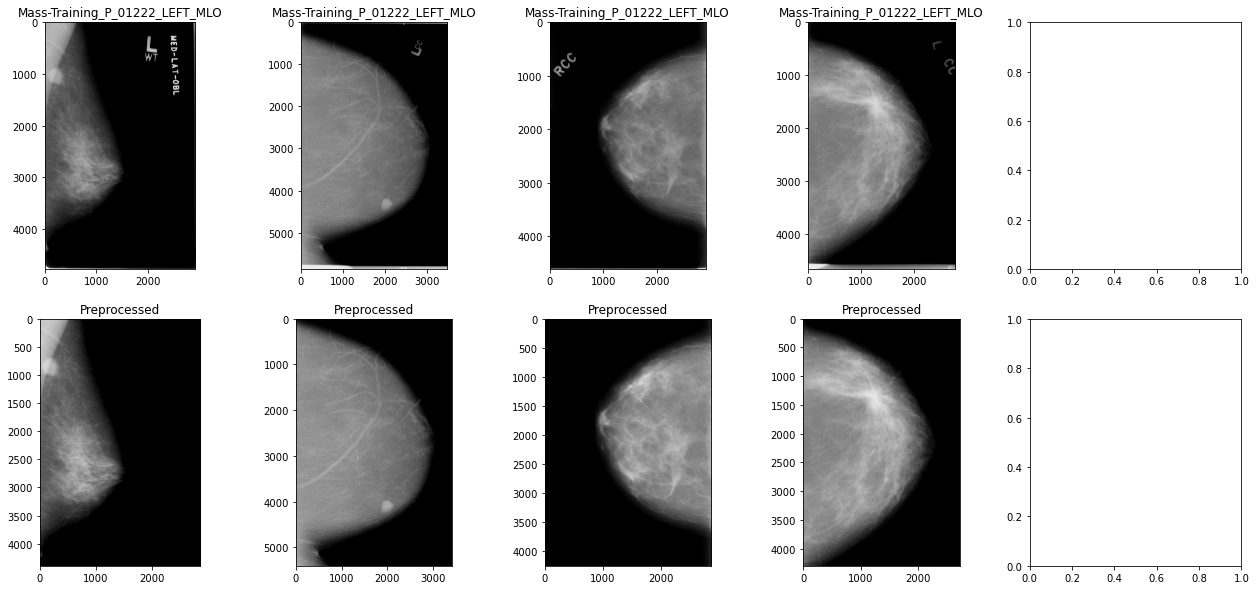

In [149]:
fig, ax = plt.subplots(nrows=2, ncols=nsamples, figsize=(22, 10))

for i in range(len(sample_initial)):
    
    # Plot original MLO scans.
    ax[0][i].imshow(sample_initial[i]["image"], cmap="gray")
    #ax[0][i].set_title(f"{sample_initial[0]["id"]}")
    ax[0][i].set_title(sample_initial[0]["id"])
    
    # Plot preprocessed MLO scans.
    ax[1][i].imshow(sample_final[i]["image"], cmap="gray")
    ax[1][i].set_title("Preprocessed")


In [175]:
#Preprocess training images - MASKS

nsamples = 5

sample_original = mask_paths_train[:nsamples]

sample_initial = []
sample_final  = []

count=0

# for fullmamm_path in fullmamm_paths_train:
#for fullmamm_path in sample_original:
for mask_mamm_path in tqdm(mask_paths_train):
    # Read full mammogram .dcm file.
    ds = pydicom.dcmread(mask_mamm_path)

    # Get relevant metadata from .dcm file.
    patient_id = ds.PatientID
    
    maksmamm = ds.pixel_array
    
    # =========================
    # Preprocess Full Mammogram
    # =========================
    
    # Step 1: Initial crop.
    
    cropped_img = cropBorders(img=maksmamm)
    
    # # Step 2: Remove artefacts.
    # binarised_img = OwnGlobalBinarise(img=cropped_img, thresh=0.1, maxval=1.0)
    # edited_mask = editMask(mask=binarised_img, ksize=(23, 23), operation="open")
    # _, xlargest_mask = xLargestBlobs(mask=edited_mask, top_x=1)
    # masked_img =applyMask(img=cropped_img, mask=xlargest_mask)
    
    mamm_pre = cropped_img
    
    # Save preprocessed full mammogram image.
    # save_filename = (
    #     os.path.basename(fullmamm_path).replace(".dcm", "")
    #     + "_PRE"
    #     + output_format
    # )
    save_filename = mask_mamm_path.split("/")[-1].replace("dcm",output_format)
    # print(">>"+output_train_full_path+"\n")
    save_path = os.path.join(output_train_mask_path, save_filename)
    cv2.imwrite(save_path, mamm_pre)
    # print(f"DONE FULL: {mask_mamm_path}")
    
    


    

100%|██████████| 1318/1318 [03:54<00:00,  5.63it/s]


In [159]:
len(fullmamm_paths_test)

0

In [165]:
#Preprocess FULL TEST images



for fullmamm_path in tqdm(fullmamm_paths_test):
# for fullmamm_path in sample_original:
    # Read full mammogram .dcm file.
    ds = pydicom.dcmread(fullmamm_path)

    # Get relevant metadata from .dcm file.
    patient_id = ds.PatientID
    
    fullmamm = ds.pixel_array
    
    # =========================
    # Preprocess Full Mammogram
    # =========================
    
    # Step 1: Initial crop.
    cropped_img = cropBorders(img=fullmamm)
    
    # Step 2: Remove artefacts.
    binarised_img = OwnGlobalBinarise(img=cropped_img, thresh=0.1, maxval=1.0)
    edited_mask = editMask(mask=binarised_img, ksize=(23, 23), operation="open")
    _, xlargest_mask = xLargestBlobs(mask=edited_mask, top_x=1)
    masked_img =applyMask(img=cropped_img, mask=xlargest_mask)
    
    fullmamm_pre = masked_img
    
    
    save_filename = fullmamm_path.split("/")[-1].replace("dcm",output_format)
    # print(">>"+output_train_full_path+"\n")
    save_path = os.path.join(output_test_full_path, save_filename)
    cv2.imwrite(save_path, fullmamm_pre)
    # print(f"DONE FULL: {fullmamm_path}")
    
    

    

100%|██████████| 361/361 [03:13<00:00,  1.87it/s]


In [174]:
#Preprocess MASK TEST images


sample_initial = []
sample_final  = []

count=0

# for fullmamm_path in fullmamm_paths_train:
#for fullmamm_path in sample_original:
for mask_mamm_path in tqdm(mask_paths_test):
    # Read full mammogram .dcm file.
    ds = pydicom.dcmread(mask_mamm_path)

    # Get relevant metadata from .dcm file.
    patient_id = ds.PatientID
    
    maksmamm = ds.pixel_array
    
    # =========================
    # Preprocess Full Mammogram
    # =========================
    
    # Step 1: Initial crop.
    
    cropped_img = cropBorders(img=maksmamm)
    
    # # Step 2: Remove artefacts.
    # binarised_img = OwnGlobalBinarise(img=cropped_img, thresh=0.1, maxval=1.0)
    # edited_mask = editMask(mask=binarised_img, ksize=(23, 23), operation="open")
    # _, xlargest_mask = xLargestBlobs(mask=edited_mask, top_x=1)
    # masked_img =applyMask(img=cropped_img, mask=xlargest_mask)
    
    mamm_pre = cropped_img
    
    # Save preprocessed full mammogram image.
    # save_filename = (
    #     os.path.basename(fullmamm_path).replace(".dcm", "")
    #     + "_PRE"
    #     + output_format
    # )
    save_filename = mask_mamm_path.split("/")[-1].replace("dcm",output_format)
    # print(">>"+output_train_full_path+"\n")
    save_path = os.path.join(output_test_mask_path, save_filename)
    cv2.imwrite(save_path, mamm_pre)
    # print(f"DONE FULL: {mask_mamm_path}")
    print(save_path)

  1%|▏         | 5/378 [00:00<00:16, 23.01it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00200_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01825_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01690_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01068_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00893_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00662_LEFT_MLO_MASK_1.png


  3%|▎         | 12/378 [00:00<00:12, 28.23it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00296_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01298_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00194_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01566_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01090_LEFT_CC_MASK_2.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00391_RIGHT_MLO_MASK_1.png


  4%|▍         | 16/378 [00:00<00:11, 30.93it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00381_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00820_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01796_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00662_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01213_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00677_RIGHT_CC_MASK_1.png


  6%|▌         | 23/378 [00:00<00:13, 27.22it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01381_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00202_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00198_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01145_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00629_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00391_LEFT_CC_MASK_1.png


  8%|▊         | 29/378 [00:01<00:12, 27.12it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01416_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01502_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00324_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00773_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00494_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01090_RIGHT_MLO_MASK_1.png


  9%|▉         | 35/378 [00:01<00:12, 26.87it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01778_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00629_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00212_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00591_RIGHT_MLO_MASK_3.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00394_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00203_LEFT_MLO_MASK_1.png


 11%|█         | 41/378 [00:01<00:13, 24.46it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00209_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01331_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01110_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00158_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01741_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00490_RIGHT_CC_MASK_1.png


 13%|█▎        | 48/378 [00:01<00:12, 26.49it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01518_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00962_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00173_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01623_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00340_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00192_RIGHT_CC_MASK_1.png


 15%|█▍        | 55/378 [00:02<00:11, 27.88it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01213_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01566_RIGHT_CC_MASK_2.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01323_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00979_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00016_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00343_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01307_RIGHT_CC_MASK_1.png


 16%|█▋        | 62/378 [00:02<00:10, 28.82it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01014_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00457_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01378_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00718_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00457_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00343_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00601_LEFT_CC_MASK_1.png


 18%|█▊        | 68/378 [00:02<00:10, 28.62it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00612_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00979_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01395_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01690_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01167_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01566_RIGHT_MLO_MASK_1.png


 20%|█▉        | 74/378 [00:02<00:10, 29.03it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00741_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00358_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00203_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00177_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00951_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00928_RIGHT_MLO_MASK_2.png


 20%|██        | 77/378 [00:02<00:10, 28.63it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01204_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01322_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01090_LEFT_CC_MASK_3.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00875_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01787_LEFT_CC_MASK_1.png


 22%|██▏       | 83/378 [00:03<00:10, 27.72it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00347_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01595_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00500_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01807_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00510_LEFT_CC_MASK_4.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00387_RIGHT_CC_MASK_1.png


 23%|██▎       | 86/378 [00:03<00:11, 26.28it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00498_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01502_LEFT_CC_MASK_1.png


 24%|██▍       | 92/378 [00:03<00:13, 21.03it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00379_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00200_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00985_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00470_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01795_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00433_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00145_LEFT_CC_MASK_1.png


 26%|██▌       | 99/378 [00:03<00:11, 24.63it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01599_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01347_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00131_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00238_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01183_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00481_RIGHT_MLO_MASK_1.png


 28%|██▊       | 105/378 [00:03<00:10, 26.36it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00893_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00147_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01640_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00131_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00116_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01661_LEFT_MLO_MASK_1.png


 29%|██▉       | 111/378 [00:04<00:09, 26.72it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00510_LEFT_MLO_MASK_2.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00198_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01489_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00882_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01108_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01719_RIGHT_CC_MASK_1.png


 31%|███       | 117/378 [00:04<00:10, 25.15it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00587_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01697_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01765_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00951_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01251_LEFT_CC_MASK_1.png


 32%|███▏      | 120/378 [00:04<00:10, 25.47it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01684_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01090_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00359_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00118_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01333_LEFT_CC_MASK_1.png


 34%|███▎      | 127/378 [00:04<00:09, 27.69it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01378_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00037_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00707_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00017_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00544_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00171_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00124_RIGHT_CC_MASK_1.png


 35%|███▍      | 131/378 [00:04<00:08, 27.61it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01645_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00788_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01114_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01912_RIGHT_MLO_MASK_1.png


 35%|███▌      | 134/378 [00:05<00:15, 15.44it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00324_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00145_LEFT_MLO_MASK_1.png


 36%|███▌      | 137/378 [00:05<00:20, 11.59it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01316_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01140_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00032_RIGHT_MLO_MASK_1.png


 37%|███▋      | 139/378 [00:06<00:25,  9.35it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01614_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00116_RIGHT_CC_MASK_1.png


 37%|███▋      | 141/378 [00:06<00:28,  8.39it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00118_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01796_LEFT_MLO_MASK_1.png


 38%|███▊      | 143/378 [00:06<00:31,  7.55it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00969_LEFT_CC_MASK_1.png


 38%|███▊      | 144/378 [00:07<00:33,  7.00it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01333_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00066_LEFT_CC_MASK_1.png


 39%|███▉      | 147/378 [00:07<00:34,  6.69it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01381_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01090_LEFT_MLO_MASK_1.png


 39%|███▉      | 149/378 [00:07<00:30,  7.40it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00516_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00433_LEFT_MLO_MASK_1.png


 40%|███▉      | 150/378 [00:07<00:33,  6.80it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00601_LEFT_MLO_MASK_2.png


 40%|████      | 152/378 [00:08<00:35,  6.43it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01719_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01395_RIGHT_CC_MASK_1.png


 41%|████      | 154/378 [00:08<00:31,  7.09it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01677_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01257_RIGHT_CC_MASK_1.png


 41%|████▏     | 156/378 [00:08<00:35,  6.29it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01477_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00615_RIGHT_MLO_MASK_1.png


 42%|████▏     | 158/378 [00:09<00:37,  5.91it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01551_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00405_LEFT_CC_MASK_1.png


 42%|████▏     | 160/378 [00:09<00:34,  6.36it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01140_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01351_LEFT_CC_MASK_1.png


 43%|████▎     | 161/378 [00:09<00:31,  6.82it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00470_RIGHT_CC_MASK_1.png


 43%|████▎     | 162/378 [00:09<00:37,  5.75it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01795_LEFT_MLO_MASK_1.png


 43%|████▎     | 163/378 [00:10<00:41,  5.24it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00494_RIGHT_MLO_MASK_1.png


 44%|████▎     | 165/378 [00:10<00:57,  3.72it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01187_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01651_RIGHT_MLO_MASK_1.png


 44%|████▍     | 167/378 [00:11<00:44,  4.69it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00405_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01254_RIGHT_CC_MASK_1.png


 44%|████▍     | 168/378 [00:11<00:42,  4.91it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00159_RIGHT_MLO_MASK_1.png


 45%|████▍     | 170/378 [00:11<00:43,  4.74it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01797_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00641_RIGHT_MLO_MASK_1.png


 45%|████▌     | 171/378 [00:11<00:38,  5.41it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01539_RIGHT_MLO_MASK_1.png


 46%|████▌     | 173/378 [00:12<00:38,  5.32it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00147_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00116_RIGHT_MLO_MASK_2.png


 46%|████▋     | 175/378 [00:12<00:32,  6.25it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00987_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00200_LEFT_CC_MASK_1.png


 47%|████▋     | 177/378 [00:12<00:27,  7.24it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00391_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00200_LEFT_MLO_MASK_1.png


 47%|████▋     | 178/378 [00:13<00:28,  7.06it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00173_RIGHT_MLO_MASK_2.png


 47%|████▋     | 179/378 [00:13<00:36,  5.48it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00980_LEFT_CC_MASK_1.png


 48%|████▊     | 181/378 [00:13<00:35,  5.50it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01106_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00369_LEFT_CC_MASK_1.png


 48%|████▊     | 183/378 [00:13<00:30,  6.39it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01192_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00173_RIGHT_MLO_MASK_1.png


 49%|████▉     | 185/378 [00:14<00:24,  7.73it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00429_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00296_LEFT_MLO_MASK_1.png


 49%|████▉     | 186/378 [00:14<00:24,  7.72it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00171_RIGHT_MLO_MASK_1.png


 50%|████▉     | 188/378 [00:14<00:28,  6.75it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00875_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00623_LEFT_CC_MASK_1.png


 50%|█████     | 190/378 [00:14<00:27,  6.77it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00230_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01666_RIGHT_CC_MASK_1.png


 51%|█████     | 192/378 [00:15<00:28,  6.57it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00173_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01348_LEFT_MLO_MASK_1.png


 51%|█████▏    | 194/378 [00:15<00:30,  6.09it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00951_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01254_RIGHT_MLO_MASK_1.png


 52%|█████▏    | 196/378 [00:15<00:30,  6.00it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01741_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01716_RIGHT_MLO_MASK_1.png


 52%|█████▏    | 198/378 [00:16<00:29,  6.20it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00576_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01316_RIGHT_CC_MASK_1.png


 53%|█████▎    | 200/378 [00:16<00:23,  7.51it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00347_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00533_LEFT_CC_MASK_1.png


 53%|█████▎    | 202/378 [00:16<00:26,  6.58it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00652_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00516_LEFT_CC_MASK_1.png


 54%|█████▍    | 204/378 [00:17<00:22,  7.64it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00766_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00947_RIGHT_MLO_MASK_1.png


 54%|█████▍    | 205/378 [00:17<00:24,  7.20it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01101_LEFT_CC_MASK_1.png


 55%|█████▍    | 207/378 [00:17<00:28,  5.97it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00980_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01044_LEFT_MLO_MASK_1.png


 55%|█████▌    | 209/378 [00:17<00:27,  6.05it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00615_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00924_RIGHT_CC_MASK_1.png


 56%|█████▌    | 211/378 [00:18<00:24,  6.83it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00177_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00598_LEFT_CC_MASK_1.png


 56%|█████▋    | 213/378 [00:18<00:24,  6.63it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01815_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01590_LEFT_MLO_MASK_1.png


 57%|█████▋    | 215/378 [00:18<00:23,  7.02it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00381_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01331_LEFT_MLO_MASK_1.png


 57%|█████▋    | 217/378 [00:19<00:20,  7.81it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01566_RIGHT_MLO_MASK_3.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01684_LEFT_CC_MASK_1.png


 58%|█████▊    | 218/378 [00:19<00:20,  7.91it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01378_RIGHT_MLO_MASK_1.png


 58%|█████▊    | 219/378 [00:19<00:23,  6.64it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00671_LEFT_CC_MASK_1.png


 58%|█████▊    | 221/378 [00:19<00:27,  5.64it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01251_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01590_LEFT_CC_MASK_1.png


 59%|█████▉    | 223/378 [00:20<00:26,  5.82it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00813_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00037_RIGHT_MLO_MASK_1.png


 59%|█████▉    | 224/378 [00:20<00:23,  6.47it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00533_LEFT_MLO_MASK_1.png


 60%|█████▉    | 225/378 [00:20<00:25,  5.90it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01323_LEFT_CC_MASK_1.png


 60%|██████    | 227/378 [00:20<00:26,  5.75it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00278_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01518_LEFT_CC_MASK_1.png


 61%|██████    | 229/378 [00:21<00:22,  6.71it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00699_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00126_RIGHT_CC_MASK_1.png


 61%|██████    | 231/378 [00:21<00:19,  7.60it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00699_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01539_RIGHT_CC_MASK_1.png


 62%|██████▏   | 233/378 [00:21<00:20,  7.06it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00032_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00837_RIGHT_MLO_MASK_1.png


 62%|██████▏   | 235/378 [00:21<00:19,  7.32it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00947_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00490_RIGHT_MLO_MASK_1.png


 63%|██████▎   | 237/378 [00:22<00:19,  7.24it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00962_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00932_LEFT_MLO_MASK_1.png


 63%|██████▎   | 239/378 [00:22<00:17,  8.01it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01800_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01467_RIGHT_CC_MASK_2.png


 64%|██████▍   | 241/378 [00:22<00:19,  7.13it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00766_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00986_LEFT_MLO_MASK_1.png


 64%|██████▍   | 242/378 [00:22<00:19,  6.85it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01298_LEFT_MLO_MASK_1.png


 65%|██████▍   | 244/378 [00:23<00:22,  6.08it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00498_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00173_RIGHT_CC_MASK_2.png


 65%|██████▌   | 246/378 [00:23<00:20,  6.29it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01119_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00343_RIGHT_MLO_MASK_1.png


 66%|██████▌   | 248/378 [00:23<00:19,  6.62it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00758_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01294_RIGHT_CC_MASK_1.png


 66%|██████▌   | 250/378 [00:24<00:17,  7.17it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00922_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00837_RIGHT_CC_MASK_1.png


 67%|██████▋   | 252/378 [00:24<00:18,  6.87it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00464_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00598_LEFT_MLO_MASK_1.png


 67%|██████▋   | 254/378 [00:24<00:17,  7.03it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00278_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01277_RIGHT_CC_MASK_1.png


 68%|██████▊   | 256/378 [00:25<00:19,  6.22it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01090_LEFT_MLO_MASK_3.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00202_RIGHT_CC_MASK_1.png


 68%|██████▊   | 258/378 [00:25<00:16,  7.29it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00738_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00212_RIGHT_MLO_MASK_1.png


 69%|██████▉   | 260/378 [00:25<00:15,  7.62it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01815_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00707_RIGHT_MLO_MASK_1.png


 69%|██████▉   | 261/378 [00:25<00:15,  7.78it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01595_LEFT_CC_MASK_1.png


 70%|██████▉   | 263/378 [00:25<00:16,  7.14it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01090_LEFT_MLO_MASK_2.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00922_RIGHT_MLO_MASK_1.png


 70%|███████   | 265/378 [00:26<00:19,  5.79it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01716_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01558_RIGHT_CC_MASK_1.png


 71%|███████   | 267/378 [00:26<00:17,  6.22it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00409_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00126_RIGHT_MLO_MASK_1.png


 71%|███████   | 269/378 [00:26<00:14,  7.34it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01912_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00987_LEFT_CC_MASK_1.png


 72%|███████▏  | 271/378 [00:27<00:14,  7.40it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01617_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01661_LEFT_CC_MASK_1.png


 72%|███████▏  | 273/378 [00:27<00:13,  7.96it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00482_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00066_LEFT_MLO_MASK_1.png


 73%|███████▎  | 275/378 [00:27<00:14,  7.16it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01599_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00773_LEFT_MLO_MASK_1.png


 73%|███████▎  | 276/378 [00:27<00:16,  6.18it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01797_LEFT_MLO_MASK_1.png


 74%|███████▎  | 278/378 [00:28<00:16,  6.10it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01697_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00343_RIGHT_MLO_MASK_2.png


 74%|███████▍  | 280/378 [00:28<00:13,  7.08it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00882_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00493_RIGHT_CC_MASK_1.png


 75%|███████▍  | 282/378 [00:28<00:13,  7.37it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01277_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01512_LEFT_CC_MASK_1.png


 75%|███████▍  | 283/378 [00:29<00:25,  3.78it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00482_LEFT_CC_MASK_1.png


 75%|███████▌  | 285/378 [00:29<00:21,  4.34it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01673_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00741_LEFT_MLO_MASK_1.png


 76%|███████▌  | 287/378 [00:29<00:15,  6.06it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01765_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00016_LEFT_MLO_MASK_1.png


 76%|███████▋  | 289/378 [00:30<00:13,  6.45it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00758_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00238_RIGHT_CC_MASK_1.png


 77%|███████▋  | 291/378 [00:30<00:12,  6.75it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01510_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01014_LEFT_MLO_MASK_1.png


 78%|███████▊  | 293/378 [00:30<00:14,  5.77it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00587_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01546_LEFT_MLO_MASK_1.png


 78%|███████▊  | 295/378 [00:31<00:12,  6.46it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00369_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00738_RIGHT_MLO_MASK_1.png


 78%|███████▊  | 296/378 [00:31<00:12,  6.35it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00391_RIGHT_CC_MASK_1.png


 79%|███████▊  | 297/378 [00:31<00:14,  5.55it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01825_RIGHT_CC_MASK_1.png


 79%|███████▉  | 299/378 [00:31<00:15,  5.24it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00524_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00017_LEFT_MLO_MASK_1.png


 80%|███████▉  | 301/378 [00:32<00:11,  6.52it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01566_RIGHT_MLO_MASK_2.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01833_RIGHT_MLO_MASK_1.png


 80%|████████  | 303/378 [00:32<00:11,  6.40it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00194_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01666_RIGHT_MLO_MASK_1.png


 81%|████████  | 305/378 [00:32<00:11,  6.27it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00820_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00636_RIGHT_MLO_MASK_1.png


 81%|████████  | 307/378 [00:33<00:09,  7.40it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00343_RIGHT_CC_MASK_2.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00375_RIGHT_MLO_MASK_1.png


 81%|████████▏ | 308/378 [00:33<00:09,  7.27it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00928_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00116_RIGHT_CC_MASK_2.png


 82%|████████▏ | 311/378 [00:33<00:09,  6.79it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00409_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01800_LEFT_MLO_MASK_1.png


 83%|████████▎ | 312/378 [00:33<00:09,  7.30it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00387_RIGHT_MLO_MASK_1.png


 83%|████████▎ | 314/378 [00:34<00:10,  6.27it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01235_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01347_RIGHT_CC_MASK_1.png


 83%|████████▎ | 315/378 [00:34<00:10,  5.92it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00464_RIGHT_CC_MASK_1.png


 84%|████████▎ | 316/378 [00:34<00:11,  5.60it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01416_RIGHT_CC_MASK_1.png


 84%|████████▍ | 318/378 [00:34<00:10,  5.85it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00969_LEFT_CC_MASK_3.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01119_LEFT_MLO_MASK_1.png


 85%|████████▍ | 320/378 [00:35<00:09,  6.36it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00114_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01623_RIGHT_CC_MASK_1.png


 85%|████████▌ | 322/378 [00:35<00:09,  5.95it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01183_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01534_RIGHT_CC_MASK_1.png


 86%|████████▌ | 324/378 [00:35<00:08,  6.13it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01294_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00636_RIGHT_CC_MASK_1.png


 86%|████████▌ | 326/378 [00:36<00:07,  7.18it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00544_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01651_RIGHT_CC_MASK_1.png


 87%|████████▋ | 327/378 [00:36<00:07,  7.00it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00671_LEFT_MLO_MASK_1.png


 87%|████████▋ | 328/378 [00:36<00:08,  6.05it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01673_RIGHT_MLO_MASK_1.png


 87%|████████▋ | 330/378 [00:36<00:09,  5.05it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00656_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01558_RIGHT_MLO_MASK_1.png


 88%|████████▊ | 332/378 [00:37<00:07,  5.92it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01800_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01605_LEFT_CC_MASK_2.png


 88%|████████▊ | 334/378 [00:37<00:06,  6.74it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00375_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00623_LEFT_MLO_MASK_1.png


 89%|████████▉ | 336/378 [00:37<00:05,  7.72it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00942_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00985_RIGHT_CC_MASK_1.png


 89%|████████▉ | 338/378 [00:37<00:05,  7.77it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01307_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01257_RIGHT_MLO_MASK_1.png


 90%|████████▉ | 339/378 [00:38<00:05,  7.11it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01726_RIGHT_MLO_MASK_1.png


 90%|█████████ | 341/378 [00:38<00:05,  6.59it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00576_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00429_LEFT_CC_MASK_1.png


 91%|█████████ | 343/378 [00:38<00:05,  6.54it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00379_LEFT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00966_RIGHT_MLO_MASK_1.png


 91%|█████████▏| 345/378 [00:39<00:04,  6.69it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00820_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01108_RIGHT_MLO_MASK_1.png


 92%|█████████▏| 346/378 [00:39<00:04,  6.97it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01204_RIGHT_CC_MASK_1.png


 92%|█████████▏| 348/378 [00:39<00:05,  5.45it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01578_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01726_RIGHT_CC_MASK_1.png


 93%|█████████▎| 350/378 [00:39<00:04,  5.90it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01617_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01192_LEFT_MLO_MASK_1.png


 93%|█████████▎| 351/378 [00:40<00:04,  5.51it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00969_LEFT_MLO_MASK_4.png


 93%|█████████▎| 352/378 [00:40<00:05,  4.75it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00969_LEFT_MLO_MASK_1.png


 94%|█████████▎| 354/378 [00:40<00:04,  4.84it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01551_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00173_LEFT_MLO_MASK_1.png


 94%|█████████▍| 355/378 [00:41<00:04,  4.79it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00099_LEFT_MLO_MASK_1.png


 94%|█████████▍| 357/378 [00:41<00:03,  5.29it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00641_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00358_RIGHT_MLO_MASK_1.png


 95%|█████████▍| 358/378 [00:41<00:03,  5.35it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01365_LEFT_CC_MASK_2.png


 95%|█████████▍| 359/378 [00:41<00:03,  5.08it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01787_LEFT_MLO_MASK_1.png


 95%|█████████▌| 360/378 [00:42<00:03,  4.68it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00524_LEFT_CC_MASK_1.png


 96%|█████████▌| 362/378 [00:42<00:03,  4.88it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01090_LEFT_MLO_MASK_4.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00820_RIGHT_CC_MASK_1.png


 96%|█████████▌| 363/378 [00:42<00:03,  4.86it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01512_LEFT_MLO_MASK_1.png


 96%|█████████▋| 364/378 [00:42<00:03,  4.66it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00230_RIGHT_CC_MASK_1.png


 97%|█████████▋| 366/378 [00:43<00:02,  4.84it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01210_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00481_RIGHT_CC_MASK_1.png


 97%|█████████▋| 368/378 [00:43<00:01,  5.41it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00343_RIGHT_CC_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00928_RIGHT_CC_MASK_1.png


 98%|█████████▊| 369/378 [00:43<00:01,  5.69it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01510_RIGHT_CC_MASK_1.png


 98%|█████████▊| 370/378 [00:44<00:01,  5.24it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00639_LEFT_MLO_MASK_1.png


 98%|█████████▊| 372/378 [00:44<00:01,  5.26it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00514_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00156_RIGHT_MLO_MASK_1.png


 99%|█████████▉| 374/378 [00:44<00:00,  5.62it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00677_RIGHT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01865_LEFT_MLO_MASK_1.png


 99%|█████████▉| 375/378 [00:44<00:00,  6.45it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00056_LEFT_MLO_MASK_1.png
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01546_LEFT_CC_MASK_1.png


100%|█████████▉| 377/378 [00:45<00:00,  5.78it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01534_RIGHT_MLO_MASK_1.png


100%|██████████| 378/378 [00:45<00:00,  8.30it/s]

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_01322_RIGHT_CC_MASK_1.png


In [168]:
save_path

'/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00524_LEFT_CC_FULL.png'